<h2 align=center> <b><u> Fine-Tuning BERT to predict Closed Questions on Stack Overflow </u></b>
</h2>

### 1. Check GPU Availability and install dependencies

In [1]:
!nvidia-smi

Tue May  7 02:21:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              28W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
!pip install tensorflow_text
# After running this cell, we have to restart the Kernel!

In [2]:
import tensorflow_text as text  # Registers the ops.

2024-05-07 02:21:56.140311: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 02:21:56.140414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 02:21:56.257821: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 2. Import the Closed Questions on Stack Overflow Dataset

In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [4]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.15.0
Eager mode:  True
Hub version:  0.16.1
GPU is available


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("/kaggle/input/predict-closed-questions-on-stack-overflow/train-sample.csv")
df.shape

(140272, 15)

In [6]:
df.tail(5)

,PostId,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,Tag1,Tag2,Tag3,Tag4,Tag5,PostClosedDate,OpenStatus
140267,2982729,06/06/2010 01:03:41,8303,09/15/2008 15:40:08,520,34,Is it possible to implement bitwise operators ...,I am facing a rather peculiar problem. I am wo...,bitwise-operators,discrete-mathematics,compiler-optimization,NaN,NaN,NaN,open
140268,8809105,01/10/2012 19:13:53,1130251,01/04/2012 15:31:10,1,0,Ruby on Rails: MySql Gem does not work: uninit...,I have the following installed:\r\nMac Os 10.7...,mysql,ruby-on-rails,gem,osx-lion,NaN,NaN,open
140269,10674791,05/20/2012 15:36:31,1388595,05/11/2012 04:43:47,4,0,deleting image from image folder,I am working with an asp.net application.I wan...,asp.net,NaN,NaN,NaN,NaN,05/21/2012 21:21:27,not a real question
140270,3997045,10/22/2010 13:04:30,484232,10/22/2010 13:04:30,1,0,Need help making HTML's,Hi to all the gurus out there.\r\n\r\nAnybody ...,html,copy,remove,move,NaN,10/22/2010 13:10:28,not a real question
140271,11570849,07/19/2012 23:36:57,1539253,07/19/2012 22:17:04,3,1,How dangerous is it to output certain content ...,Following on from a question I asked about esc...,php,content-management-system,NaN,NaN,NaN,NaN,open


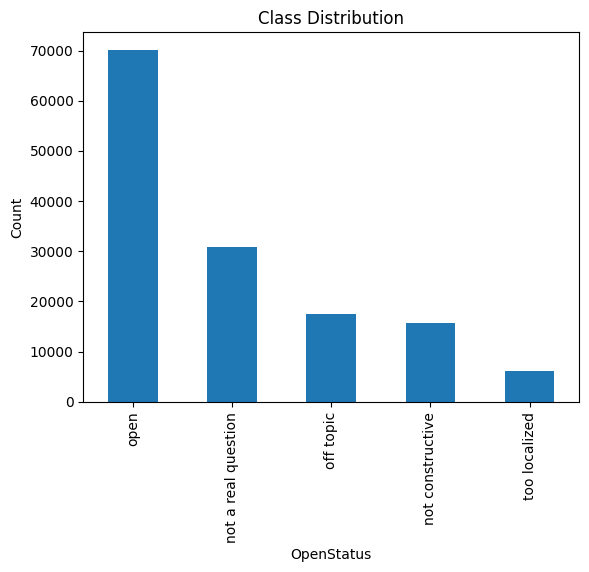

In [7]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing the 'OpenStatus' column
df['OpenStatus'].value_counts().plot(kind='bar', title='Class Distribution')
plt.xlabel('OpenStatus')
plt.ylabel('Count')
plt.show()

In [8]:
# Checking the number of samples from each class

class_distribution = df['OpenStatus'].value_counts()
print(class_distribution)

OpenStatus
open                   70136
not a real question    30789
off topic              17530
not constructive       15659
too localized           6158
Name: count, dtype: int64


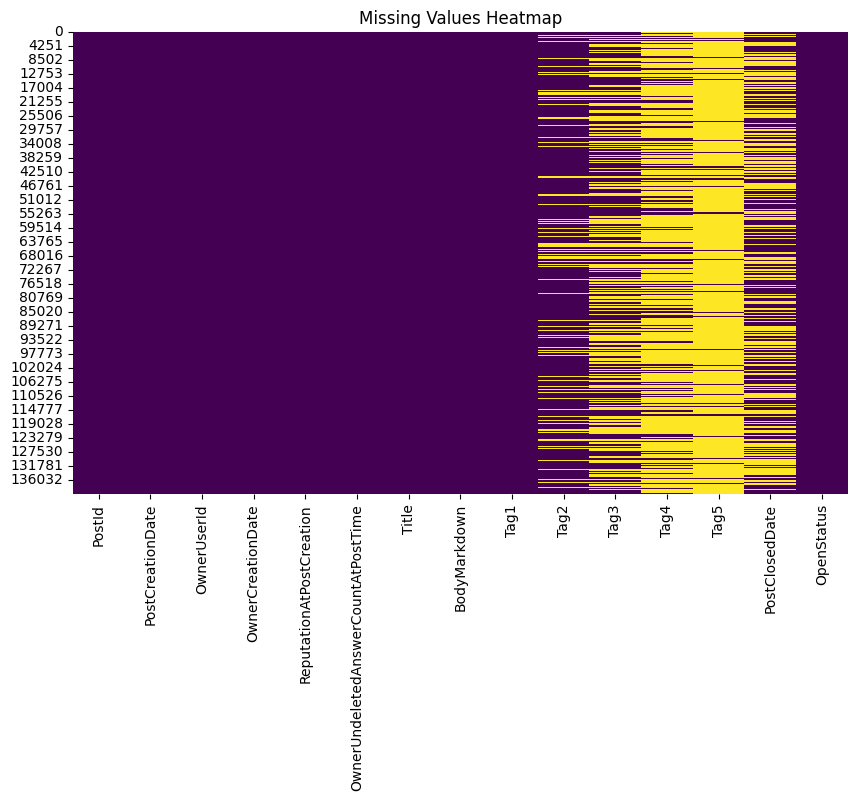

In [9]:
# Checking for missing values

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame
# Create a boolean DataFrame indicating missing values
missing_values = df.isnull()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(missing_values, cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

### 3. Preparing Input Data for Training and Evaluation

In [10]:
from sklearn.model_selection import train_test_split


# Splitting the dataset into train, validation and test (70%, 20% and 10% respectively)
train_df, remaining = train_test_split(df, random_state=42, train_size=0.8, stratify=df.OpenStatus.values)
valid_df, test_df = train_test_split(remaining, random_state=42, train_size=0.50, stratify=remaining.OpenStatus.values)



# Display the shapes of the downsampled training and validation datasets
train_df.shape, valid_df.shape, test_df.shape

((112217, 15), (14027, 15), (14028, 15))

In [11]:
# Checking the number of samples from each class of train_df

class_distribution = train_df['OpenStatus'].value_counts()
print(class_distribution)

OpenStatus
open                   56109
not a real question    24631
off topic              14024
not constructive       12527
too localized           4926
Name: count, dtype: int64


The given dataset has a tremendous data imbalance for different classes. One possible approach can be to downsample all of 'open', 'not a real question', 'off topic' and 'not constructive' classes to the size of the 'too localized' class.

In [12]:
from sklearn.utils import resample

# Separating different classes in the dataset
open_class = train_df[train_df.OpenStatus == 'open']
not_a_real_question_class = train_df[train_df.OpenStatus == 'not a real question']
off_topic_class = train_df[train_df.OpenStatus == 'off topic']
not_constructive_class = train_df[train_df.OpenStatus == 'not constructive']
too_localized_class = train_df[train_df.OpenStatus == 'too localized']


# Downsampling the 5 classes to the size of the 'off topic' class
open_class = resample(open_class,
                      replace=False,  # sample without replacement
                      n_samples=len(too_localized_class),  # match target class size
                      random_state=42)  # for reproducible results

not_a_real_question_class = resample(not_a_real_question_class,
                                     replace=False,  # sample without replacement
                                     n_samples=len(too_localized_class),  # match target class size
                                     random_state=42)  # for reproducible results

off_topic_class = resample(off_topic_class,
                                     replace=False,  # sample without replacement
                                     n_samples=len(too_localized_class),  # match target class size
                                     random_state=42)  # for reproducible results

not_constructive_class = resample(not_constructive_class,
                                     replace=False,  # sample without replacement
                                     n_samples=len(too_localized_class),  # match target class size
                                     random_state=42)  # for reproducible results

# Combining all the minority class with the resampled classes
train_df = pd.concat([open_class, 
                not_a_real_question_class, 
                off_topic_class, 
                not_constructive_class, 
                too_localized_class])

# Shuffle the downsampled training dataset
train_df = train_df.sample(frac=1, random_state=42)

In [13]:
train_df.shape

(24630, 15)

In [14]:
# Checking the number of samples from each class of train_df

class_distribution = train_df['OpenStatus'].value_counts()
print(class_distribution)

OpenStatus
too localized          4926
off topic              4926
not a real question    4926
not constructive       4926
open                   4926
Name: count, dtype: int64


In [15]:
train_df.tail(5)

,PostId,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,Tag1,Tag2,Tag3,Tag4,Tag5,PostClosedDate,OpenStatus
136603,8308545,11/29/2011 09:37:53,834663,07/08/2011 03:12:08,1,0,cant find org/apache/ibatis/io/Resources,I use **mybatis** and **struts1** I want to ad...,mybatis,struts1,NaN,NaN,NaN,04/20/2012 15:26:06,too localized
14150,3717059,09/15/2010 11:16:09,445646,09/12/2010 16:05:54,6,0,PHP-Framework or CMS .. ?,I want to know that which framework/CMS is the...,php,frameworks,content-management-system,NaN,NaN,09/15/2010 11:52:29,not a real question
109104,7207041,08/26/2011 15:25:15,835038,07/08/2011 08:54:05,143,2,Looking for Locations API (c#),In my app i am allowing users to enter there c...,c#,NaN,NaN,NaN,NaN,NaN,open
135635,6737574,07/18/2011 18:31:12,301736,03/25/2010 13:53:40,49,0,Simple Silverlight Examples,I have just started learning silverlight. When...,silverlight-4.0,NaN,NaN,NaN,NaN,05/23/2012 08:54:38,not constructive
73465,11249188,06/28/2012 16:39:44,499017,11/06/2010 03:46:32,1,0,Call to undefined method stdClass::onDisplay()...,I have a joomla 2.5 installation. I just insta...,php,joomla2.5,stdclass,NaN,NaN,07/02/2012 03:16:24,too localized


I have decided to use only the "Title", "BodyMarkdown" and "OpenStatus" columns from the dataframe. The "Title" and  "BodyMarkdown" can be joined together to create the text input and the "OpenStatus" column is our target column.

In [16]:
selected_columns = ['Title', 'BodyMarkdown', 'OpenStatus', 'Tag1', 'Tag2', 'Tag3', 'Tag4', 'Tag5']
train_df = train_df[selected_columns]
valid_df = valid_df[selected_columns]
test_df = test_df[selected_columns]

In [17]:
train_df.tail(5)

,Title,BodyMarkdown,OpenStatus,Tag1,Tag2,Tag3,Tag4,Tag5
136603,cant find org/apache/ibatis/io/Resources,I use **mybatis** and **struts1** I want to ad...,too localized,mybatis,struts1,NaN,NaN,NaN
14150,PHP-Framework or CMS .. ?,I want to know that which framework/CMS is the...,not a real question,php,frameworks,content-management-system,NaN,NaN
109104,Looking for Locations API (c#),In my app i am allowing users to enter there c...,open,c#,NaN,NaN,NaN,NaN
135635,Simple Silverlight Examples,I have just started learning silverlight. When...,not constructive,silverlight-4.0,NaN,NaN,NaN,NaN
73465,Call to undefined method stdClass::onDisplay()...,I have a joomla 2.5 installation. I just insta...,too localized,php,joomla2.5,stdclass,NaN,NaN


Here, I have combined the "Title", "Tag1 to Tag5" and "BodyMarkdown" columns to create a single text input.

In [18]:
for index, row in train_df.iterrows():
    text = "Title: " + "'" + row.Title + "'" 
    #text += " Tags: {" + ', '.join(str(tag) for tag in [row.Tag1, row.Tag2, row.Tag3, row.Tag4, row.Tag5] if not pd.isnull(tag)) + "}"
    text += "  Body: " + "'" + row.BodyMarkdown + "'"
    train_df.at[index, 'text'] = text
    

for index, row in valid_df.iterrows():
    text = "Title: " + "'" + row.Title + "'" 
    #text += " Tags: {" + ', '.join(str(tag) for tag in [row.Tag1, row.Tag2, row.Tag3, row.Tag4, row.Tag5] if not pd.isnull(tag)) + "}" 
    text += "  Body: " + "'" + row.BodyMarkdown + "'"
    valid_df.at[index, 'text'] = text

for index, row in test_df.iterrows():
    text = "Title: " + "'" + row.Title + "'" 
    #text += " Tags: {" + ', '.join(str(tag) for tag in [row.Tag1, row.Tag2, row.Tag3, row.Tag4, row.Tag5] if not pd.isnull(tag)) + "}"
    text += "  Body: " + "'" + row.BodyMarkdown + "'"
    test_df.at[index, 'text'] = text

In [19]:
train_df.tail(5)

,Title,BodyMarkdown,OpenStatus,Tag1,Tag2,Tag3,Tag4,Tag5,text
136603,cant find org/apache/ibatis/io/Resources,I use **mybatis** and **struts1** I want to ad...,too localized,mybatis,struts1,NaN,NaN,NaN,Title: 'cant find org/apache/ibatis/io/Resourc...
14150,PHP-Framework or CMS .. ?,I want to know that which framework/CMS is the...,not a real question,php,frameworks,content-management-system,NaN,NaN,Title: 'PHP-Framework or CMS .. ?' Body: 'I w...
109104,Looking for Locations API (c#),In my app i am allowing users to enter there c...,open,c#,NaN,NaN,NaN,NaN,Title: 'Looking for Locations API (c#)' Body:...
135635,Simple Silverlight Examples,I have just started learning silverlight. When...,not constructive,silverlight-4.0,NaN,NaN,NaN,NaN,Title: 'Simple Silverlight Examples' Body: 'I...
73465,Call to undefined method stdClass::onDisplay()...,I have a joomla 2.5 installation. I just insta...,too localized,php,joomla2.5,stdclass,NaN,NaN,Title: 'Call to undefined method stdClass::onD...


Now, I have dropped the "Title" and "BodyMarkdown" columns from the dataframe.

In [20]:
columns_to_drop = ['Title', 'BodyMarkdown']
train_df.drop(columns=columns_to_drop, inplace=True)
valid_df.drop(columns=columns_to_drop, inplace=True)
test_df.drop(columns=columns_to_drop, inplace=True)

In [21]:
train_df.shape

(24630, 7)

In [22]:
train_df.tail(5)

,OpenStatus,Tag1,Tag2,Tag3,Tag4,Tag5,text
136603,too localized,mybatis,struts1,NaN,NaN,NaN,Title: 'cant find org/apache/ibatis/io/Resourc...
14150,not a real question,php,frameworks,content-management-system,NaN,NaN,Title: 'PHP-Framework or CMS .. ?' Body: 'I w...
109104,open,c#,NaN,NaN,NaN,NaN,Title: 'Looking for Locations API (c#)' Body:...
135635,not constructive,silverlight-4.0,NaN,NaN,NaN,NaN,Title: 'Simple Silverlight Examples' Body: 'I...
73465,too localized,php,joomla2.5,stdclass,NaN,NaN,Title: 'Call to undefined method stdClass::onD...


In [23]:
for index, row in train_df.iterrows():
    print("Text: ")
    print("________________________")
    print(row.text, end='\n\n\n\n')
    print("Target Class:")
    print("________________________")
    print(row.OpenStatus)
    break

Text: 
________________________
Title: 'My application works on all browsers, but in IE doesn't work, it works in debug mode in IE only,'  Body: 'this is the application I developed: games.ourcity-sy.com

in IE(I tried 9 and 8)  and  it doesn't work well in the normal mode, but when I get to debug mode F12, it works with some problems,

what could be the solution??'



Target Class:
________________________
too localized


Now we have to encode the Target column into numerical values.

In [24]:
# Definelabel mapping
custom_label_mapping = {'open': 0, 
                        'not a real question': 1, 
                        'off topic': 2,
                        'not constructive': 3, 
                        'too localized': 4
                       }  

# Initialize LabelEncoder with custom mapping
encoded_labels = []
for index, row in train_df.iterrows():
    label = row['OpenStatus']
    encoded_label = custom_label_mapping[label]
    encoded_labels.append(encoded_label)

# Add the encoded labels as a new column in the DataFrame
train_df['OpenStatus_encoded'] = encoded_labels



# Applying the same changes to valid_df and test_df

encoded_labels = []
for index, row in valid_df.iterrows():
    label = row['OpenStatus']
    encoded_label = custom_label_mapping[label]
    encoded_labels.append(encoded_label)

# Add the encoded labels as a new column in the DataFrame
valid_df['OpenStatus_encoded'] = encoded_labels



encoded_labels = []
for index, row in test_df.iterrows():
    label = row['OpenStatus']
    encoded_label = custom_label_mapping[label]
    encoded_labels.append(encoded_label)

# Add the encoded labels as a new column in the DataFrame
test_df['OpenStatus_encoded'] = encoded_labels

In [25]:
train_df.tail(5)

,OpenStatus,Tag1,Tag2,Tag3,Tag4,Tag5,text,OpenStatus_encoded
136603,too localized,mybatis,struts1,NaN,NaN,NaN,Title: 'cant find org/apache/ibatis/io/Resourc...,4
14150,not a real question,php,frameworks,content-management-system,NaN,NaN,Title: 'PHP-Framework or CMS .. ?' Body: 'I w...,1
109104,open,c#,NaN,NaN,NaN,NaN,Title: 'Looking for Locations API (c#)' Body:...,0
135635,not constructive,silverlight-4.0,NaN,NaN,NaN,NaN,Title: 'Simple Silverlight Examples' Body: 'I...,3
73465,too localized,php,joomla2.5,stdclass,NaN,NaN,Title: 'Call to undefined method stdClass::onD...,4


In [26]:
train_df.shape

(24630, 8)

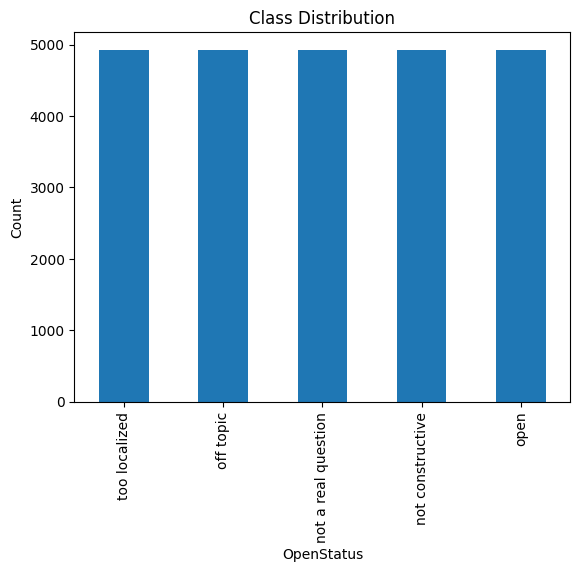

In [27]:
# Assuming df is your DataFrame containing the 'OpenStatus' column
train_df['OpenStatus'].value_counts().plot(kind='bar', title='Class Distribution')
plt.xlabel('OpenStatus')
plt.ylabel('Count')
plt.show()

In [28]:
X_train = train_df["text"]
y_train = train_df["OpenStatus_encoded"]

X_valid = valid_df["text"]
y_valid = valid_df["OpenStatus_encoded"]

X_test = test_df["text"]
y_test = test_df["OpenStatus_encoded"]

In [29]:
print(X_train.shape)
print(y_train.shape)

print(X_valid.shape)
print(y_valid.shape)

print(X_test.shape)
print(y_test.shape)

(24630,)
(24630,)
(14027,)
(14027,)
(14028,)
(14028,)


### 4. Input Format for BERT

**Token IDs** - This corresponds to the tokenized strings padded with 0s
                upto the max sequence length and beginning with CLS and ending with SEP. <br><br>
**Input Mask** - Note that BERT uses Self-Attention Networks to provide
                 contextualised embeddings corresponding to each token in the token string i.e., for each word in the string BERT looks to the left and right of it in the sentence so as to find contextual meaning of the word in the sentence (say, if there is a "the", then look at the noun to which it points). Now, note that we have padded our token strings with 0s upto the max seq length, but we do not want the padding 0s to influence the contextual information to be derived.  The Input Mask is a list of same length as the length of Token Ids (ie the max seq length) where there is a 0 for a padding and 1 for a valid token. The 0s will cancel out the internal multiplications that we perform for capturing the Self Attention for contextual information. <br><br>

**Input Type IDs** - Note that originally BERT was pretrained on two   tasks, Masked Language Modelling (where random words from the sentence would be masked and it would be the task for the BERT to predict what those masked words are) and the other task was Next Sentence Prediction or NSP (Given two sentences, the BERT has to predict which came first and which came after. The first sentence was given the value 0 and the next sentence was given the value 1).<br><br>
**In Text classification, we are dealing with only 1 sequence at a time, so our input type IDs would just be a vector with all values 0. **


### 5. Checking the tokenization process

In [30]:
preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")

# Tokenize the input text
input_text = ["Hello, how are you?"]
tokenized_output = preprocessor(input_text)

# Print token IDs
print(tokenized_output['input_word_ids'])
print(tokenized_output['input_mask'])
print(tokenized_output['input_type_ids'])

Attaching model 'tensorflow/bert/tensorflow2/en-uncased-preprocess/3' to your Kaggle notebook...


tf.Tensor(
[[ 101 7592 1010 2129 2024 2017 1029  102    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]], shape=(1, 128), dtype=int32)
tf.Tensor(
[[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 128), dty

Upon checking the input word ids, we find that the tokens are --> "Hello", "#,", "how", "are", "you" and "#?" {'#' signifies that the succeeding character ',' is attached to characters before] and they are encoded as [7592 1010 2129 2024 2017 1029]. 

Note that this is not the whole story. We also have to make sure that each sequence is initiated with the CLS token (which signifies start of sequence and has a token_id 101) and ended with SEP (separator) which means end of sequence and has a token_id 102. Also we have to make sure that all tensors have sequence size equal to the max_sequence_length by using padding.

### 6. Add a Classification Head to the BERT Layer

We only need the pooled_output that represents the whole sentence (using the CLS token that contains the contextual information of the whole sentence) and not the sequence_output.

In [31]:
# Building the model

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-12-h-768-a-12/versions/2",
    trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].





# Classification
# Add dropout layer
drop1 = tf.keras.layers.Dropout(0.5)(pooled_output)
batch_norm1 = tf.keras.layers.BatchNormalization()(drop1)

# Add hidden dense layers
hidden1 = tf.keras.layers.Dense(512, activation='relu')(batch_norm1)
drop2 = tf.keras.layers.Dropout(0.4)(hidden1)
batch_norm2 = tf.keras.layers.BatchNormalization()(drop2)
hidden2 = tf.keras.layers.Dense(128, activation='relu')(batch_norm2)
drop3 = tf.keras.layers.Dropout(0.3)(hidden2)
batch_norm3 = tf.keras.layers.BatchNormalization()(drop3)
hidden3 = tf.keras.layers.Dense(32, activation='relu')(batch_norm3)
drop4 = tf.keras.layers.Dropout(0.2)(hidden3)
batch_norm4 = tf.keras.layers.BatchNormalization()(drop4)

# Output layer
output_layer = tf.keras.layers.Dense(5, activation='softmax', name='output')(batch_norm4)


model=tf.keras.Model(inputs=[text_input],outputs=[output_layer])

Attaching model 'tensorflow/bert/tensorflow2/en-uncased-preprocess/3' to your Kaggle notebook...
Attaching model 'tensorflow/bert/tensorflow2/bert-en-uncased-l-12-h-768-a-12/2' to your Kaggle notebook...


### 7. Fine-Tune BERT for Text Classification

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer_1 (KerasLayer)  {'input_mask': (None, 128)   0         ['input_1[0][0]']             
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [33]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',  # Path to save the best model
        save_best_only=True,  # Save only the best model
        monitor='val_accuracy',  # Quantity to be monitored
        save_weights_only=True,  # Do not save the entire model
        verbose=1,  # Verbosity mode. 0 or 1.
        save_freq='epoch'  # Save the model at the end of every epoch
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=3,  # Number of epochs with no improvement after which training will be stopped
        monitor='val_accuracy',  # Quantity to be monitored
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',  # Quantity to be monitored
        factor=0.5,  # Factor by which the learning rate will be reduced. new_lr = lr * factor
        patience=3,  # Number of epochs with no improvement after which learning rate will be reduced
        min_lr=1e-10  # Lower bound on the learning rate
    )
]

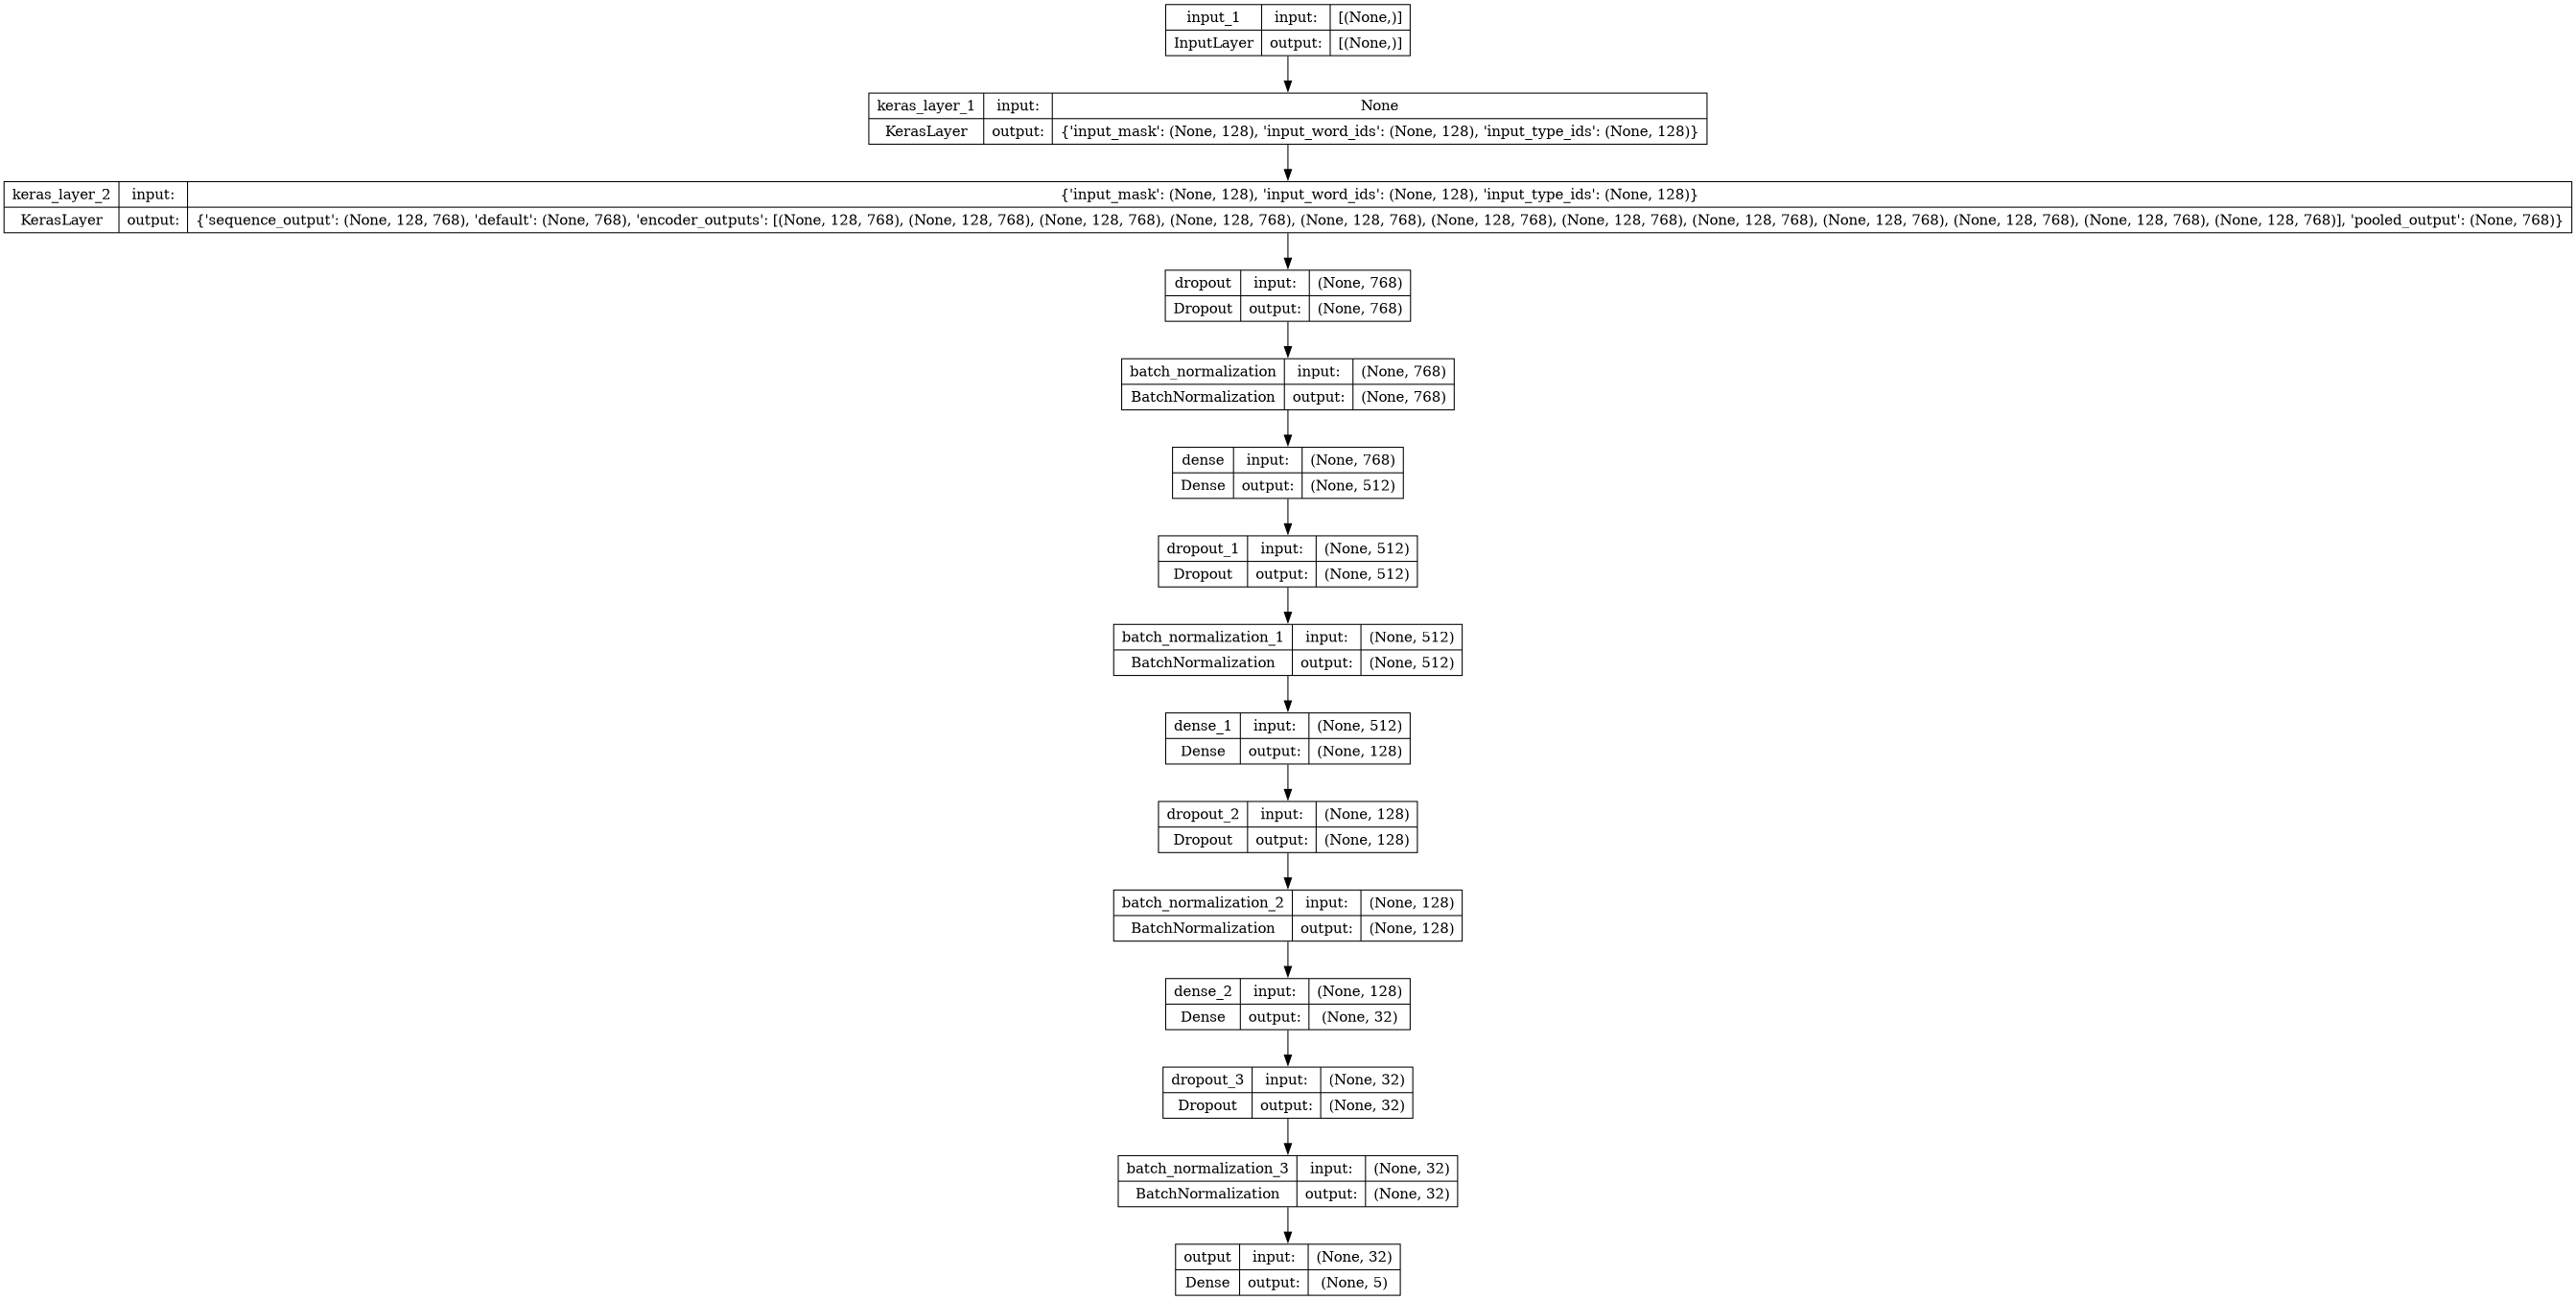

In [34]:
# Plot the model architecture
tf.keras.utils.plot_model(model, show_shapes=True, dpi=76)

In [35]:
# Train model
epochs = 10
history = model.fit(X_train, 
                    y_train,
                    validation_data = (X_valid, y_valid),
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks
                   )

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
I0000 00:00:1715048595.406381     117 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


770/770 [==============================] - ETA: 0s - loss: 1.9230 - accuracy: 0.2767
Epoch 1: val_accuracy improved from -inf to 0.40287, saving model to best_model.h5
770/770 [==============================] - 548s 657ms/step - loss: 1.9230 - accuracy: 0.2767 - val_loss: 1.4564 - val_accuracy: 0.4029 - lr: 2.0000e-05
Epoch 2/10
770/770 [==============================] - ETA: 0s - loss: 1.6186 - accuracy: 0.3726
Epoch 2: val_accuracy did not improve from 0.40287
770/770 [==============================] - 501s 651ms/step - loss: 1.6186 - accuracy: 0.3726 - val_loss: 1.4568 - val_accuracy: 0.2867 - lr: 2.0000e-05
Epoch 3/10
770/770 [==============================] - ETA: 0s - loss: 1.4172 - accuracy: 0.4460
Epoch 3: val_accuracy did not improve from 0.40287
770/770 [==============================] - 501s 650ms/step - loss: 1.4172 - accuracy: 0.4460 - val_loss: 1.5553 - val_accuracy: 0.3150 - lr: 2.0000e-05
Epoch 4/10
770/770 [==============================] - ETA: 0s - loss: 1.2908 - acc

### 8. Check the loss and accuracy curves

In [36]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

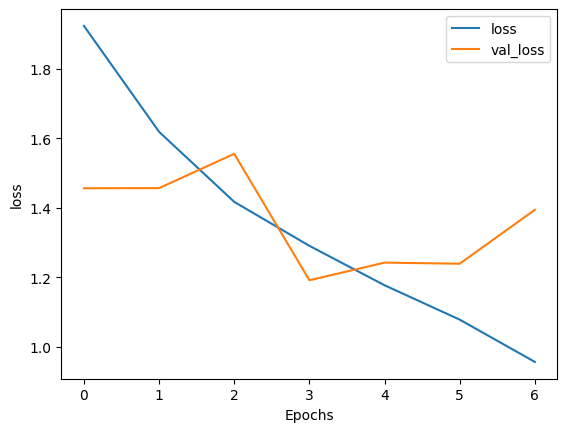

In [37]:
plot_graphs(history, 'loss')

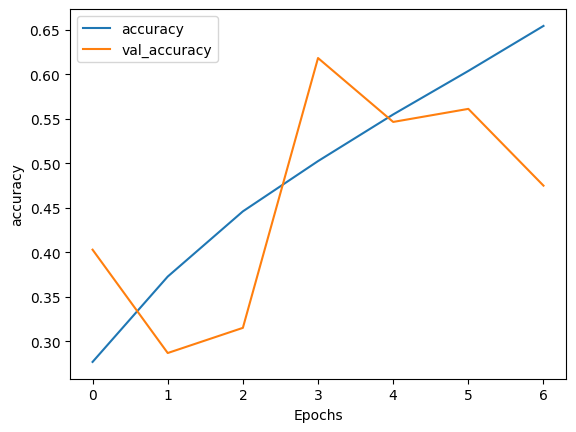

In [38]:
plot_graphs(history, 'accuracy')

## 9. Evaluating on Test Dataframe

In [39]:
from sklearn.metrics import accuracy_score, log_loss


# Obtain predictions from the BERT model
predictions = model.predict(X_test)

# Convert predictions to class labels
predicted_labels = tf.argmax(predictions, axis=1)

# Compute accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print("Accuracy:", round(accuracy * 100, 4) , "%")

# Compute sparse categorical cross-entropy loss
loss = log_loss(y_test, predictions)
print("Sparse Categorical Cross-Entropy Loss:", loss)

439/439 [==============================] - 94s 212ms/step
Accuracy: 61.7337 %
Sparse Categorical Cross-Entropy Loss: 1.1826924533810068


#### Confusion Matrix

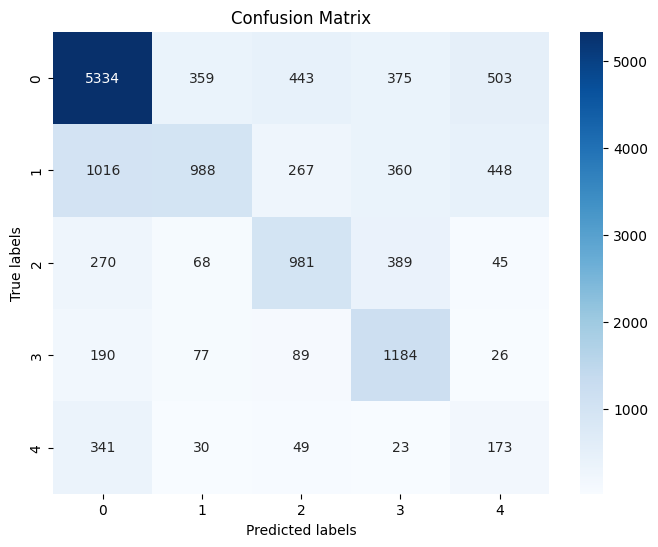

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[str(i) for i in range(5)], 
            yticklabels=[str(i) for i in range(5)])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## 10. Sanity Checks

In [41]:
import random
import matplotlib.pyplot as plt

In [42]:
X_test_list = X_test.tolist()
y_test_list = y_test.tolist()

In [43]:
print(len(X_test_list))
print(len(y_test_list))

14028
14028


custom_label_mapping = <br>{<br>'open': 0, <br>
                        'not a real question': 1, <br>
                        'off topic': 2, <br>
                        'not constructive': 3, <br>
                        'too localized': 4 <br>
                       }  

In [44]:
label_to_class_map = {0 : 'open',
                      1 : 'not a real question',
                      2 : 'off topic',
                      3 : 'not constructive',
                      4 : 'too localized'}

#### Check 1

___________________________________________________


TEXT:


Title: 'Design Question (Ruby On Rails)'  Body: 'In my system there are many types of users (4), based on the user that is logged in they have access to only certain information.

For example I am trying to do something like this in my Client model:
  
 

     class Client
         def self.allowed
            if current_user.is_a?(SuperAdmin)
              return self.all
            elsif current_user.is_a?(Client)
              return [current_user]
            elsif current_user.is_a?(ClientAdmin)
              return [current_user.client]
            end
          end
       end


The problem is, it seems my model doesn't have access to the current_user helper method.

I have 2 questions:
   

 1. How can I fix this
 2. Should logic such as getting back the allowed client be done in the model?

'



___________________________________________________


GROUND TRUTH:


open



____________________________________________

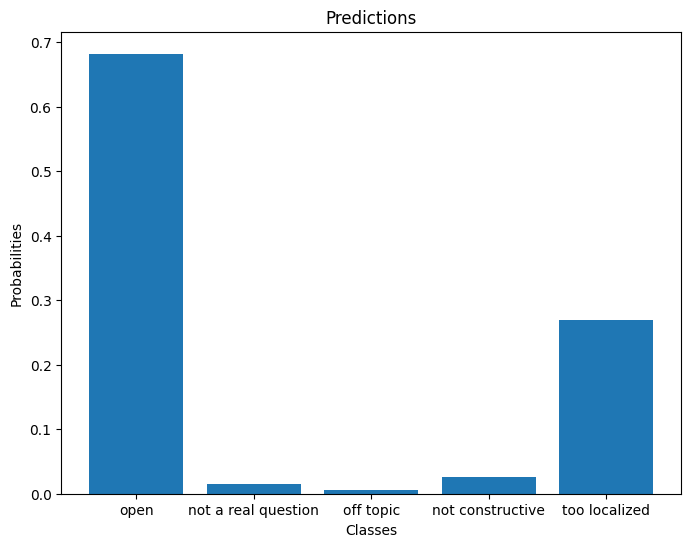




___________________________________________________


PREDICTED CLASS:  open



___________________________________________________



CORRECT PREDICTION !!!


In [52]:
# Generate a random integer between 1 and 100 (inclusive)
rand_int = random.randint(0, 14028)

print("___________________________________________________")
print("\n\nTEXT:\n\n")
print(X_test_list[rand_int])
print("\n\n")
print("___________________________________________________")
print("\n\nGROUND TRUTH:\n\n")
print(label_to_class_map[y_test_list[rand_int]])
print("\n\n")
print("___________________________________________________")


print("\n\n")
prediction = model.predict([X_test_list[rand_int]])
print("\n\nPREDICTION:\n\n")

categories = ['open', 
              'not a real question', 
              'off topic',
              'not constructive',
              'too localized'
             ]

plt.figure(figsize=(8, 6))
plt.bar(categories, prediction[0])
plt.xlabel('Classes')
plt.ylabel('Probabilities')
plt.title('Predictions')
plt.show()
print("\n\n")
print("___________________________________________________")





predicted_class_index = np.argmax(prediction)
print("\n\nPREDICTED CLASS: ", label_to_class_map[predicted_class_index])
print('\n\n')
print("___________________________________________________")



print("\n\n")
if label_to_class_map[predicted_class_index] == label_to_class_map[y_test_list[rand_int]]:
    print("CORRECT PREDICTION !!!")
else:
    print("WRONG PREDICTION !!!")

#### Check 2

___________________________________________________


TEXT:


Title: 'Reading images address from strings to set them to ids within an array'  Body: 'question might seemed messed up so i will explain - 
i have an array of imageviews Ids, 

    int[] slotArray = {R.id.imageView1,R.id.imageView2,R.id.imageView3,R.id.imageView4,
   					   R.id.imageView5,R.id.imageView6,R.id.imageView7,R.id.imageView8,
   					   R.id.imageView9,R.id.imageView10,R.id.imageView11,R.id.imageView12,
   					   R.id.imageView13,R.id.imageView14,R.id.imageView15,R.id.imageView16,};

and i have 16 images.( i want each image to be clickable seperately, that's why i chose this method. im kinda new at this, feel free to suggest better ideas :)

let say i have a string named loc that contains "@strings/picone". lets say i receive from the user, i=5, so i will need to assign the picture from the string loc to imageview6. 
how can i do that? i thought about doing something like

(ImageView)findViewById(slotArray[i])

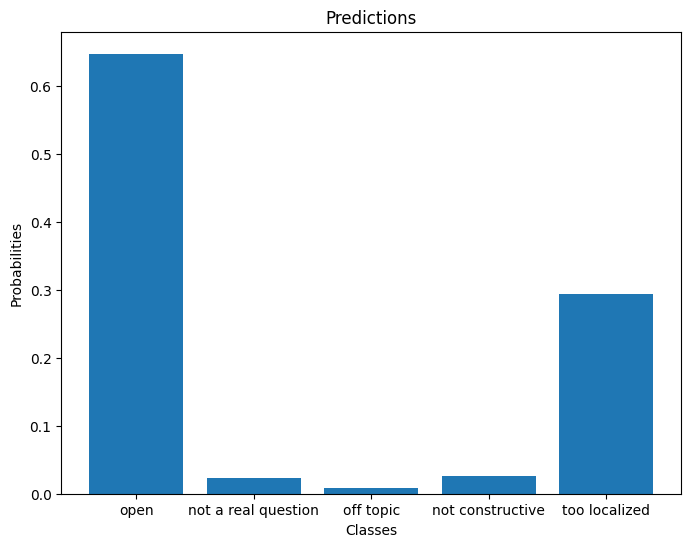




___________________________________________________


PREDICTED CLASS:  open



___________________________________________________



CORRECT PREDICTION !!!


In [51]:
# Generate a random integer between 1 and 100 (inclusive)
rand_int = random.randint(0, 14028)

print("___________________________________________________")
print("\n\nTEXT:\n\n")
print(X_test_list[rand_int])
print("\n\n")
print("___________________________________________________")
print("\n\nGROUND TRUTH:\n\n")
print(label_to_class_map[y_test_list[rand_int]])
print("\n\n")
print("___________________________________________________")


print("\n\n")
prediction = model.predict([X_test_list[rand_int]])
print("\n\nPREDICTION:\n\n")

categories = ['open', 
              'not a real question', 
              'off topic',
              'not constructive',
              'too localized'
             ]

plt.figure(figsize=(8, 6))
plt.bar(categories, prediction[0])
plt.xlabel('Classes')
plt.ylabel('Probabilities')
plt.title('Predictions')
plt.show()
print("\n\n")
print("___________________________________________________")





predicted_class_index = np.argmax(prediction)
print("\n\nPREDICTED CLASS: ", label_to_class_map[predicted_class_index])
print('\n\n')
print("___________________________________________________")



print("\n\n")
if label_to_class_map[predicted_class_index] == label_to_class_map[y_test_list[rand_int]]:
    print("CORRECT PREDICTION !!!")
else:
    print("WRONG PREDICTION !!!")

#### Check 3

___________________________________________________


TEXT:


Title: 'Inactive control background color'  Body: 'Is there a way on Windows to retrieve the color used as background color for inactive controls (`TextBox`, etc.)? Or better yet, the border color too?

This is for Windows Forms and I haven't been able to find anything suitable in `SystemColors`. There is no such thing 

Case in point. I have a text box which may not be large enough for the text it holds and it is disabled. When it is disabled the user cannot scroll to view the entire text and I can't even display a tooltip [for obvious reasons](http://blogs.msdn.com/oldnewthing/archive/2007/04/05/2028099.aspx).

So what I've done now is setting the `TextBox`'s `ReadOnly` property to `true` which allows me to display tooltips and have the control scrollable. The client now wants the text box to look like it was disabled; `ReadOnly` is a pretty nasty property since it still *looks* like it can be edited. So I thought putting 

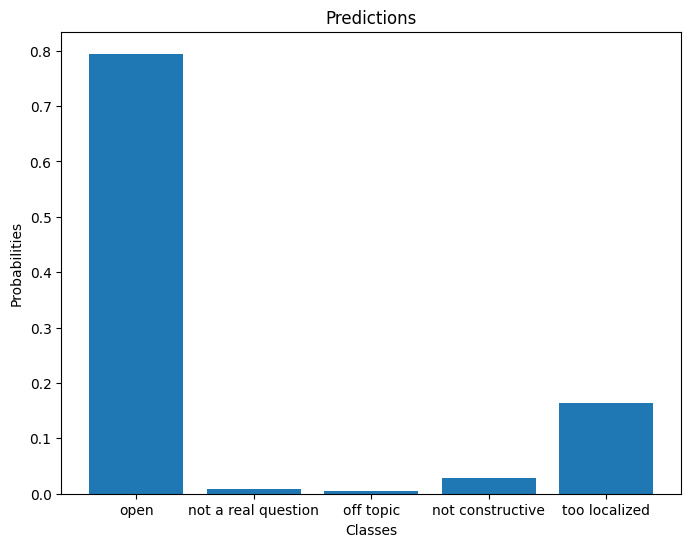




___________________________________________________


PREDICTED CLASS:  open



___________________________________________________



CORRECT PREDICTION !!!


In [47]:
# Generate a random integer between 1 and 100 (inclusive)
rand_int = random.randint(0, 14028)

print("___________________________________________________")
print("\n\nTEXT:\n\n")
print(X_test_list[rand_int])
print("\n\n")
print("___________________________________________________")
print("\n\nGROUND TRUTH:\n\n")
print(label_to_class_map[y_test_list[rand_int]])
print("\n\n")
print("___________________________________________________")


print("\n\n")
prediction = model.predict([X_test_list[rand_int]])
print("\n\nPREDICTION:\n\n")

categories = ['open', 
              'not a real question', 
              'off topic',
              'not constructive',
              'too localized'
             ]

plt.figure(figsize=(8, 6))
plt.bar(categories, prediction[0])
plt.xlabel('Classes')
plt.ylabel('Probabilities')
plt.title('Predictions')
plt.show()
print("\n\n")
print("___________________________________________________")





predicted_class_index = np.argmax(prediction)
print("\n\nPREDICTED CLASS: ", label_to_class_map[predicted_class_index])
print('\n\n')
print("___________________________________________________")



print("\n\n")
if label_to_class_map[predicted_class_index] == label_to_class_map[y_test_list[rand_int]]:
    print("CORRECT PREDICTION !!!")
else:
    print("WRONG PREDICTION !!!")

#### Check 4

___________________________________________________


TEXT:


Title: 'Java: what is faster split in a loop or doing it before'  Body: 'Goolge comes up with a lot of comparisions but not on what I am looking for:

What is better if I want to iterate through a splitted String

    String[] flagArr = flags.split(";");
    for (String f: flagArr) {
    	// some stuff
    }

OR

    for (String f: flags.split(";")) {
    	// some stuff
    }

With the second pice of code I wonder if the compiler is smart enough to do the split only once 
    '



___________________________________________________


GROUND TRUTH:


not constructive



___________________________________________________



1/1 [==============================] - 0s 38ms/step


PREDICTION:




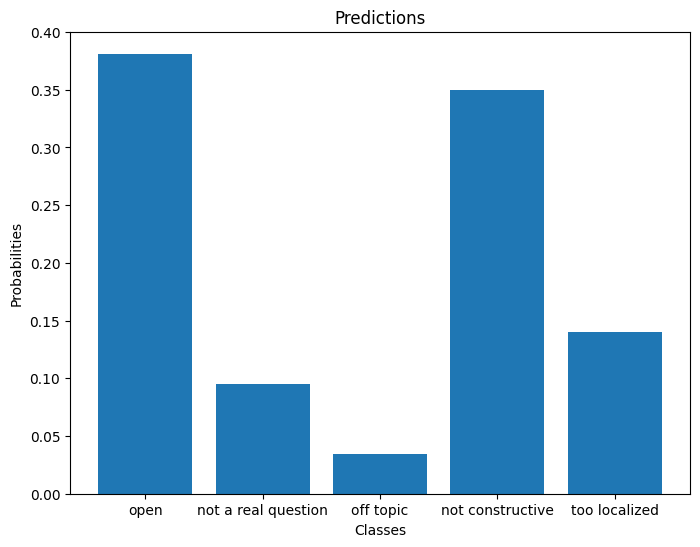




___________________________________________________


PREDICTED CLASS:  open



___________________________________________________



WRONG PREDICTION !!!


In [48]:
# Generate a random integer between 1 and 100 (inclusive)
rand_int = random.randint(0, 14028)

print("___________________________________________________")
print("\n\nTEXT:\n\n")
print(X_test_list[rand_int])
print("\n\n")
print("___________________________________________________")
print("\n\nGROUND TRUTH:\n\n")
print(label_to_class_map[y_test_list[rand_int]])
print("\n\n")
print("___________________________________________________")


print("\n\n")
prediction = model.predict([X_test_list[rand_int]])
print("\n\nPREDICTION:\n\n")

categories = ['open', 
              'not a real question', 
              'off topic',
              'not constructive',
              'too localized'
             ]

plt.figure(figsize=(8, 6))
plt.bar(categories, prediction[0])
plt.xlabel('Classes')
plt.ylabel('Probabilities')
plt.title('Predictions')
plt.show()
print("\n\n")
print("___________________________________________________")





predicted_class_index = np.argmax(prediction)
print("\n\nPREDICTED CLASS: ", label_to_class_map[predicted_class_index])
print('\n\n')
print("___________________________________________________")



print("\n\n")
if label_to_class_map[predicted_class_index] == label_to_class_map[y_test_list[rand_int]]:
    print("CORRECT PREDICTION !!!")
else:
    print("WRONG PREDICTION !!!")

#### Check 5

___________________________________________________


TEXT:


Title: 'Javascript Canvas Flowcharting Project?'  Body: 'I am looking for a Javascript project which makes use of canvas to allow the creation of drafting/flowcharts in the browser.

Are there any active projects like that alive?'



___________________________________________________


GROUND TRUTH:


not constructive



___________________________________________________



1/1 [==============================] - 0s 39ms/step


PREDICTION:




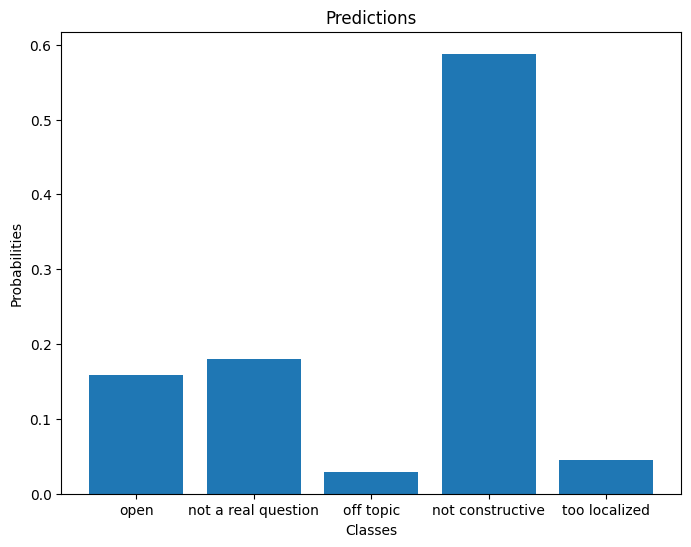




___________________________________________________


PREDICTED CLASS:  not constructive



___________________________________________________



CORRECT PREDICTION !!!


In [49]:
# Generate a random integer between 1 and 100 (inclusive)
rand_int = random.randint(0, 14028)

print("___________________________________________________")
print("\n\nTEXT:\n\n")
print(X_test_list[rand_int])
print("\n\n")
print("___________________________________________________")
print("\n\nGROUND TRUTH:\n\n")
print(label_to_class_map[y_test_list[rand_int]])
print("\n\n")
print("___________________________________________________")


print("\n\n")
prediction = model.predict([X_test_list[rand_int]])
print("\n\nPREDICTION:\n\n")

categories = ['open', 
              'not a real question', 
              'off topic',
              'not constructive',
              'too localized'
             ]

plt.figure(figsize=(8, 6))
plt.bar(categories, prediction[0])
plt.xlabel('Classes')
plt.ylabel('Probabilities')
plt.title('Predictions')
plt.show()
print("\n\n")
print("___________________________________________________")





predicted_class_index = np.argmax(prediction)
print("\n\nPREDICTED CLASS: ", label_to_class_map[predicted_class_index])
print('\n\n')
print("___________________________________________________")



print("\n\n")
if label_to_class_map[predicted_class_index] == label_to_class_map[y_test_list[rand_int]]:
    print("CORRECT PREDICTION !!!")
else:
    print("WRONG PREDICTION !!!")